# Датасет "Оставшееся количество циклов зарядки аккумулятора" 
Оригинальное название: *Battery Remaining Useful Life (RUL)*

Домашняя страница датасета:
https://github.com/ignavinuales/Battery_RUL_Prediction

На Каггле: https://www.kaggle.com/datasets/ignaciovinuales/battery-remaining-useful-life-rul

### Описание автора датасета

Гавайский Институт природной энергии протестировал 14 аккумуляторов типа NMC-LCO 18650 номинальной емкости 2.8 А·ч. Каждый аккумулятор был подвергнут более чем 1000 циклам разрядки/зарядки при температуре 25°C, включающим CC-CV зарядку в режиме C/2 и разрядку в режиме 1.5C.

На основе соответствующего датасета я создал новые признаки, описывающие динамику напряжения и силы тока для каждого цикла. Эти признаки можно использовать для предсказания оставшегося количества циклов аккумулятора. Датасет содержит сводную информацию о 14 аккумуляторах.

*The Hawaii Natural Energy Institute examined 14 NMC-LCO 18650 batteries with a nominal capacity of 2.8 Ah, which were cycled over 1000 times at 25°C with a CC-CV charge rate of C/2 rate and discharge rate of 1.5C.*

*From that source dataset, I created features that showcase the voltage and current behaviour over each cycle. Those features can be used to predict the remaining useful life (RUL) of the batteries. The dataset contains the summary of the 14 batteries.*

#### Признаки

- Индекс цикла
- F1: Полная продолжительность разрядки (с) 
- F2: Продолжительность разрядки с 3.6 В до 3.4 В (с)
- F3: Стартовое напряжение при разрядке (В)
- F4: Стартовое напряжение при зарядке (В)
- F5: Продолжительность зарядки до 4.15 В (с)
- F6: Продолжительность зарядки постоянным током (с)
- F7: Полная продолжительность зарядки (с)
- RUL: Целевая переменная (оставшееся количество циклов зарядки аккумулятора)

######
<div>
<img src="images/Voltage Discharging Cycle.png" width="550"/>
</div>

######
<div>
<img src="images/Voltage Charging Cycle.png" width="550"/>
</div>

######
<div>
<img src="images/Current Charging Cycle.png" width="550"/>
</div>



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
%matplotlib inline

In [2]:
df = pd.read_csv('data/Battery_RUL.csv')
df.drop(columns='Cycle_Index', inplace=True) # индекс не является свойством, и он может привести к data leak

In [3]:
df.head(10)

,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,2595.30,1151.488500,3.670,3.211,5460.001000,6755.01,10777.82,1112
1,7408.64,1172.512500,4.246,3.220,5508.992000,6762.02,10500.35,1111
2,7393.76,1112.992000,4.249,3.224,5508.993000,6762.02,10420.38,1110
3,7385.50,1080.320667,4.250,3.225,5502.016000,6762.02,10322.81,1109
4,65022.75,29813.487000,4.290,3.398,5480.992000,53213.54,56699.65,1107
5,3301.18,1194.235077,3.674,3.504,5023.633636,5977.38,5977.38,1106
6,5955.30,1220.135329,4.013,3.501,5017.495000,5967.55,5967.55,1105
7,5951.20,1220.135329,4.014,3.501,5017.496000,5962.21,5962.21,1104
8,5945.44,1216.920914,4.014,3.501,5009.993667,5954.91,5954.91,1103
9,435251.49,263086.078000,4.267,3.086,269.984000,443700.02,443700.02,1102


In [4]:
df.shape

(15064, 8)

In [5]:
# Для удобства переименуем столбцы согласно авторской нотации

new_col_labels = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7']

df_column_dict = dict(zip(df.columns, new_col_labels))
df_column_dict

{'Discharge Time (s)': 'F1',
 'Decrement 3.6-3.4V (s)': 'F2',
 'Max. Voltage Dischar. (V)': 'F3',
 'Min. Voltage Charg. (V)': 'F4',
 'Time at 4.15V (s)': 'F5',
 'Time constant current (s)': 'F6',
 'Charging time (s)': 'F7'}

In [6]:
df.rename(mapper=df_column_dict, axis=1, inplace=True)

## Разведочный анализ и предобработка

In [7]:
# Пропусков нет

df.isnull().sum()

F1     0
F2     0
F3     0
F4     0
F5     0
F6     0
F7     0
RUL    0
dtype: int64

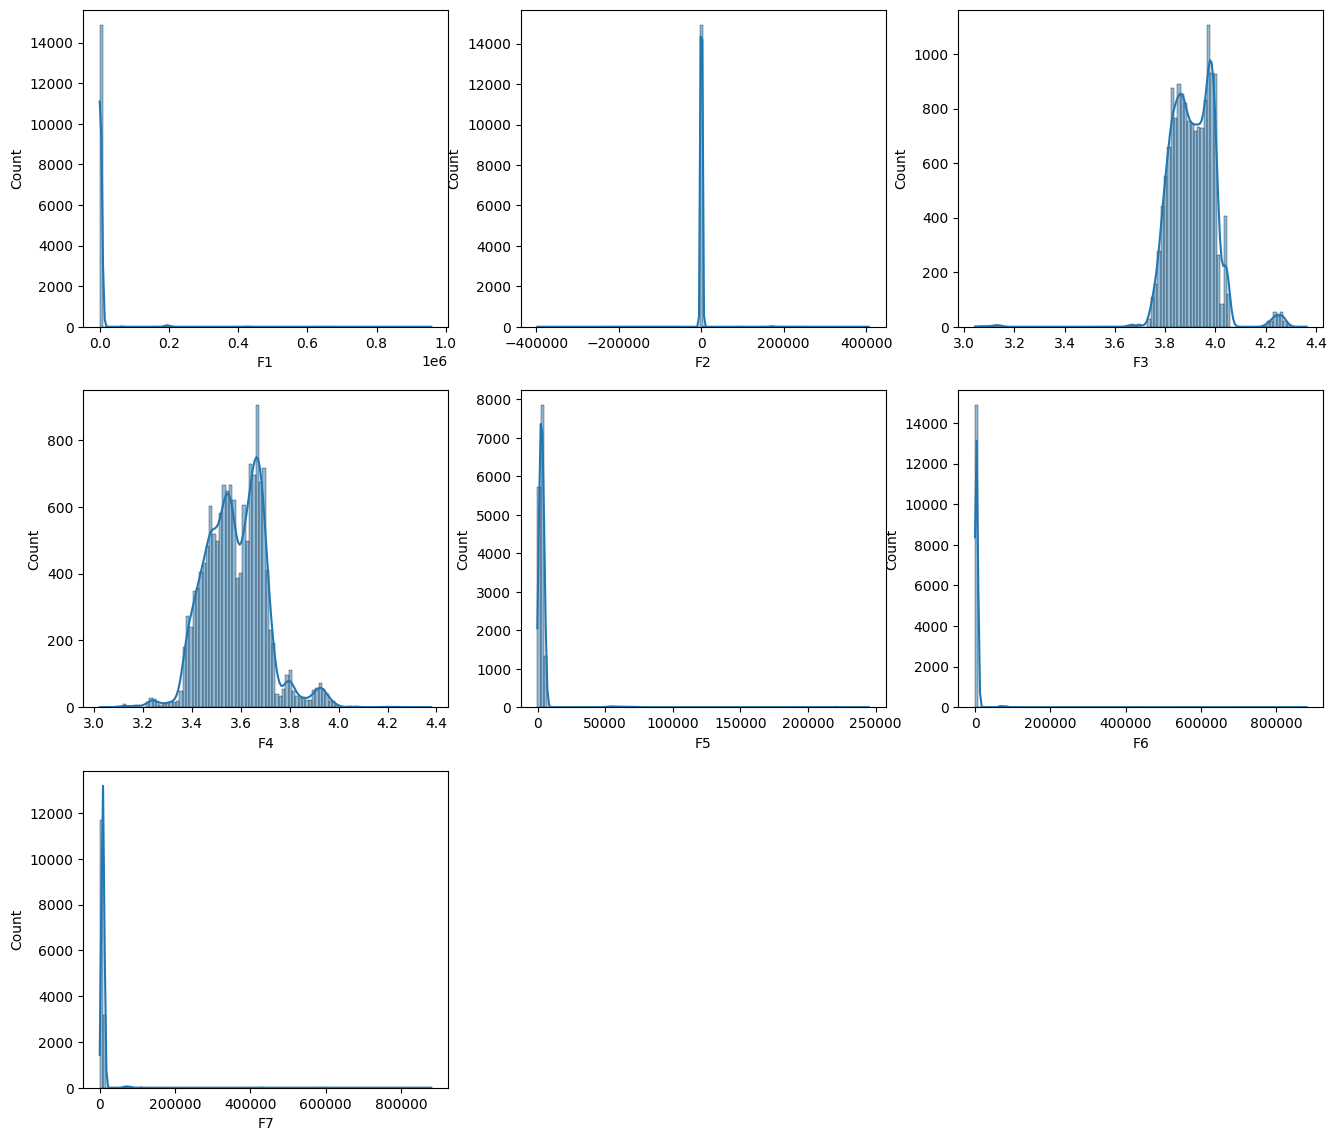

In [8]:
plt.figure(figsize=(16,14))

for i,col in enumerate(new_col_labels):    
    plt.subplot(3, 3, i + 1)
    sns.histplot(x=col, data=df, bins=100, kde=True)

plt.show()

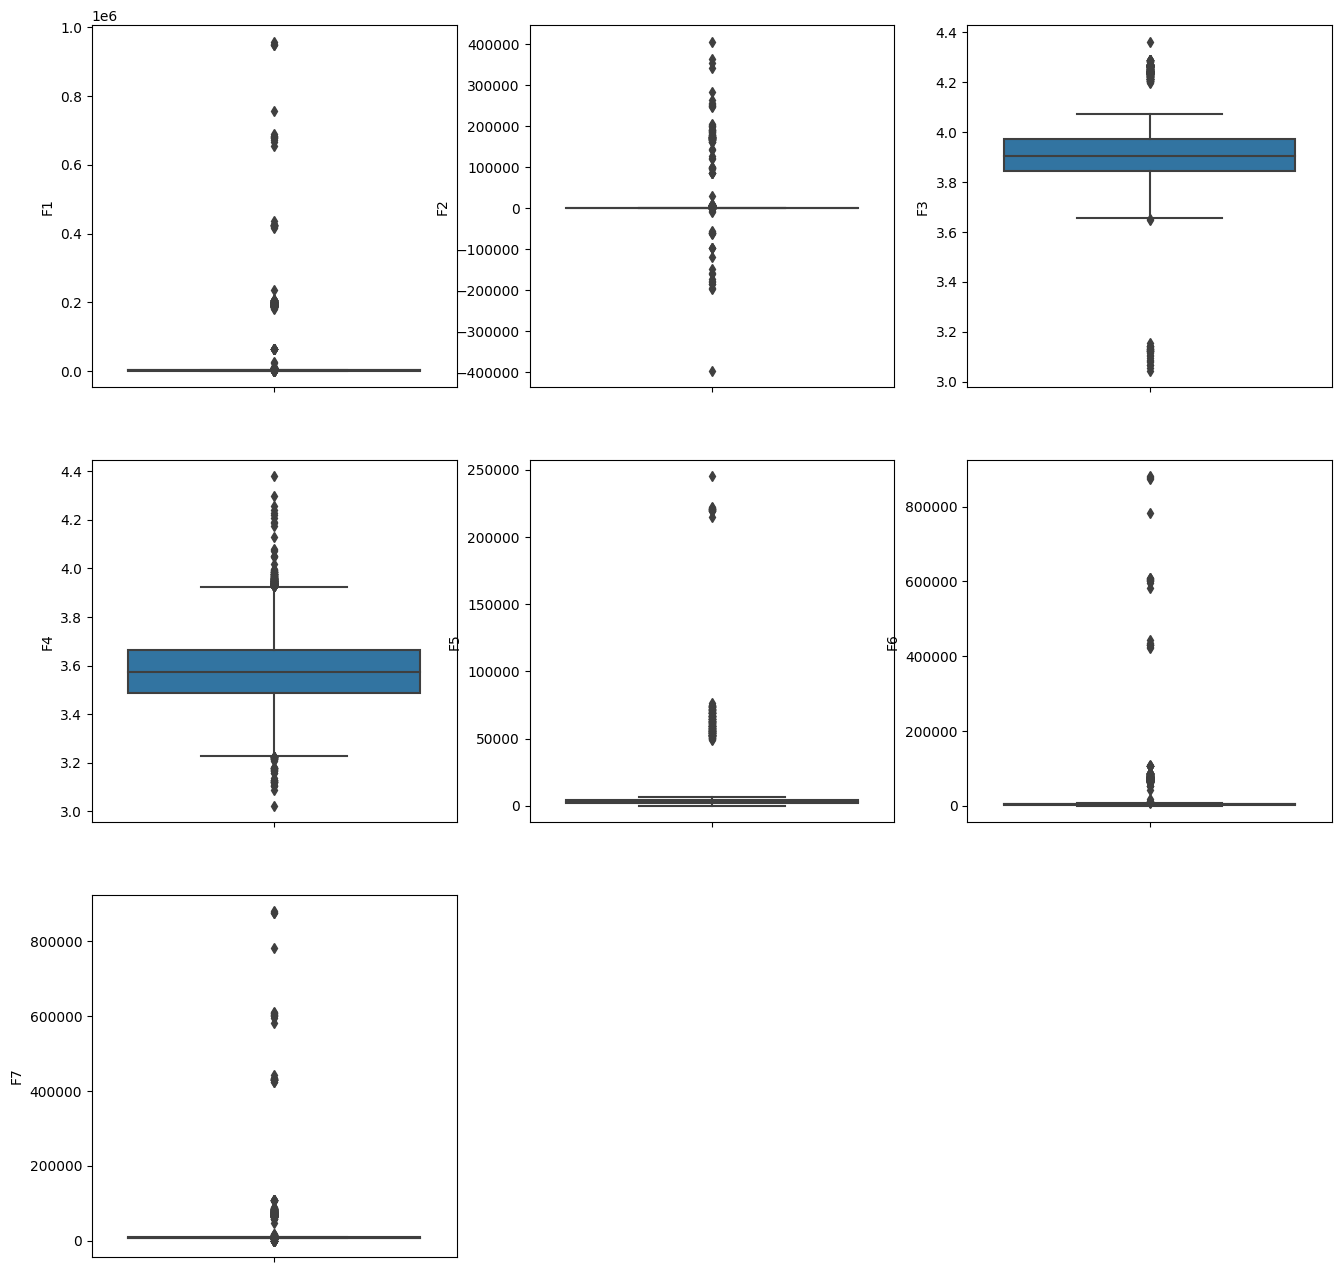

In [9]:
plt.figure(figsize=(16,16))

for i,col in enumerate(new_col_labels):    
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=col, data=df)

plt.show()

In [10]:
# У признаков F1, F2, F5, F6, F7 наблюдаются серьезные выбросы

In [11]:
df.iloc[10:19] # Пример выброса (строка 14) - значения у данных пяти признаков отличаются на 2 порядка от соседних

,F1,F2,F3,F4,F5,F6,F7,RUL
10,3228.58,1135.349333,3.689,3.485,5033.075692,5969.89,5969.89,1101
11,6019.90,1058.279724,4.045,3.475,5053.842846,5980.77,5980.77,1100
12,6026.59,1049.487845,4.047,3.477,5046.429500,5966.82,5966.82,1099
13,6008.07,1065.372059,4.045,3.480,5033.075769,5954.47,5954.47,1098
14,423271.35,168773.265000,4.270,3.108,219923.996000,430028.84,430028.84,1097
15,2261.34,883.200000,4.038,3.901,1949.664000,2922.69,6070.11,1096
16,2259.46,883.199000,4.042,3.373,5181.377000,6161.38,9310.98,1095
17,2256.61,878.400000,4.042,3.374,5181.375000,6154.37,9296.64,1094
18,2252.83,873.601000,4.043,3.374,5174.334000,6147.33,9243.58,1093


In [12]:
df.iloc[7603:7612] # Пример выброса (строка 7607) - отрицательное значение

,F1,F2,F3,F4,F5,F6,F7,RUL
7603,2188.81,818.375,4.044,3.384,5002.813,5965.38,9136.38,1049
7604,2186.38,818.438,4.044,3.385,4999.313,5958.31,9101.31,1048
7605,2186.38,818.375,4.045,3.385,4992.375,5958.38,9136.38,1047
7606,2184.00,806.375,4.026,3.705,4956.000,5922.00,9142.00,1046
7607,207013.99,-98271.841,4.272,3.159,73349.980,85080.00,85080.00,1045
7608,11755.36,807.000,4.005,3.380,5250.080,6200.48,9556.67,1044
7609,2184.00,814.400,4.008,3.389,5012.353,5948.35,9188.35,1043
7610,2183.74,816.000,4.009,3.388,5012.318,5948.32,9188.32,1042
7611,2172.00,816.000,4.009,3.389,5005.152,5948.35,9192.90,1041


In [13]:
df.iloc[11822:11831] # Пример выброса (строка 11826) - значения у данных пяти признаков отличаются на 1-3 порядка от соседних

,F1,F2,F3,F4,F5,F6,F7,RUL
11822,1017.06,273.371429,3.800,3.674,1457.375000,2096.38,7823.50,41
11823,1014.88,273.500000,3.800,3.673,1452.875000,2096.38,7793.94,40
11824,1008.00,272.457143,3.800,3.675,1448.375000,2060.38,7795.12,39
11825,1012.25,271.542857,3.799,3.676,1443.875000,2060.38,7792.44,38
11826,32.38,42.105263,3.114,3.674,114.250000,8.00,8.00,37
11827,1014.69,271.600000,3.799,3.671,1529.375000,2168.38,7963.75,36
11828,1014.62,271.657143,3.799,3.673,1448.375000,2060.38,7863.06,35
11829,1009.75,269.828571,3.799,3.673,1443.875000,2060.38,7856.69,34
11830,1007.00,268.914286,3.798,3.674,1432.884429,2060.31,7783.56,33


In [14]:
# Подобные выбросы невозможно интерпретировать как корректные результаты измерений, поэтому перед нами либо
# ошибки измерений, либо ошибки обработки. 
# Данные выбросы необходимо удалить.
# Для определения порога отсечения построим графики персентилей на концах интервалов.

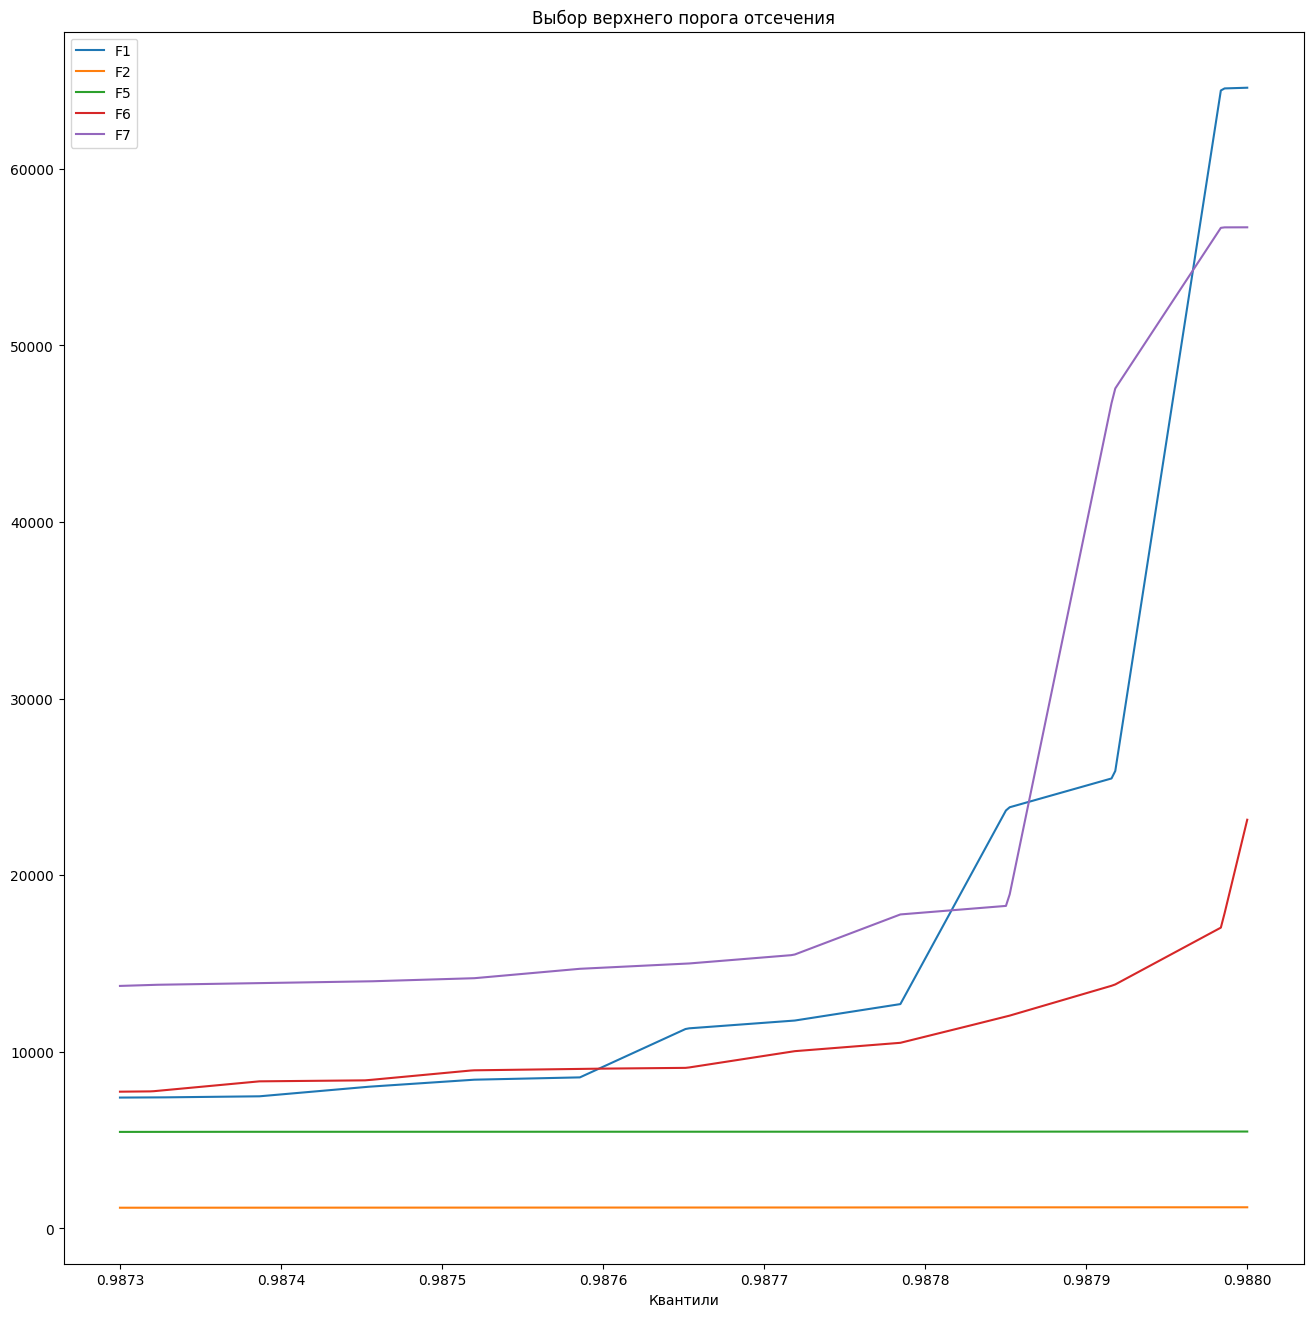

In [15]:
q0 = 0.9873
q1 = 0.9880
pts = 300

plt.figure(figsize=(16,16))
plt.plot(np.linspace(q0, q1, pts), [ df.F1.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F1')
plt.plot(np.linspace(q0, q1, pts), [ df.F2.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F2')
plt.plot(np.linspace(q0, q1, pts), [ df.F5.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F5')
plt.plot(np.linspace(q0, q1, pts), [ df.F6.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F6')
plt.plot(np.linspace(q0, q1, pts), [ df.F7.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F7')
plt.title(label='Выбор верхнего порога отсечения')
plt.xlabel('Квантили')
plt.legend()
plt.show()

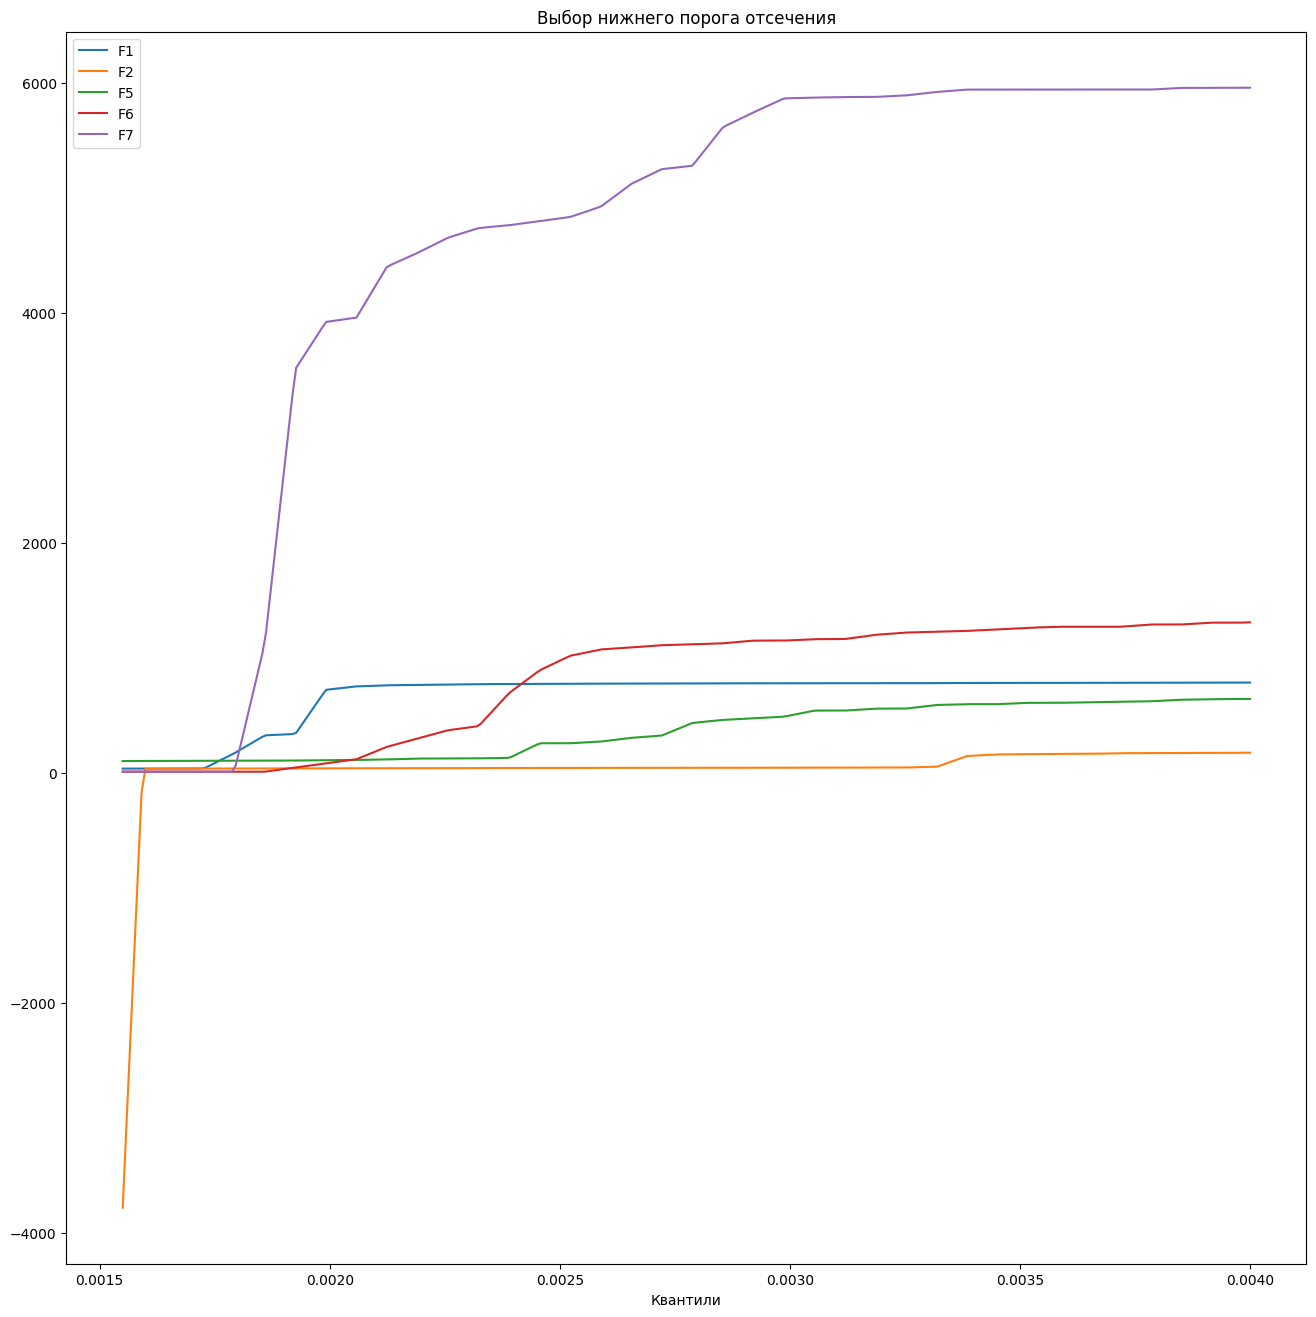

In [16]:
q0 = 0.00155
q1 = 0.0040
pts = 300

plt.figure(figsize=(16,16))
plt.plot(np.linspace(q0, q1, pts), [ df.F1.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F1')
plt.plot(np.linspace(q0, q1, pts), [ df.F2.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F2')
plt.plot(np.linspace(q0, q1, pts), [ df.F5.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F5')
plt.plot(np.linspace(q0, q1, pts), [ df.F6.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F6')
plt.plot(np.linspace(q0, q1, pts), [ df.F7.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F7')
plt.title(label='Выбор нижнего порога отсечения')
plt.xlabel('Квантили')
plt.legend()
plt.show()

In [17]:
# Будем отсекать по F7: оставим значения от 3000 до 15000

In [18]:
dfc = df[3000 < df.F7]
dfc = dfc[df.F7 < 15000]

C:\Users\Peter\AppData\Local\Temp\ipykernel_6684\1406491950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfc = dfc[df.F7 < 15000]


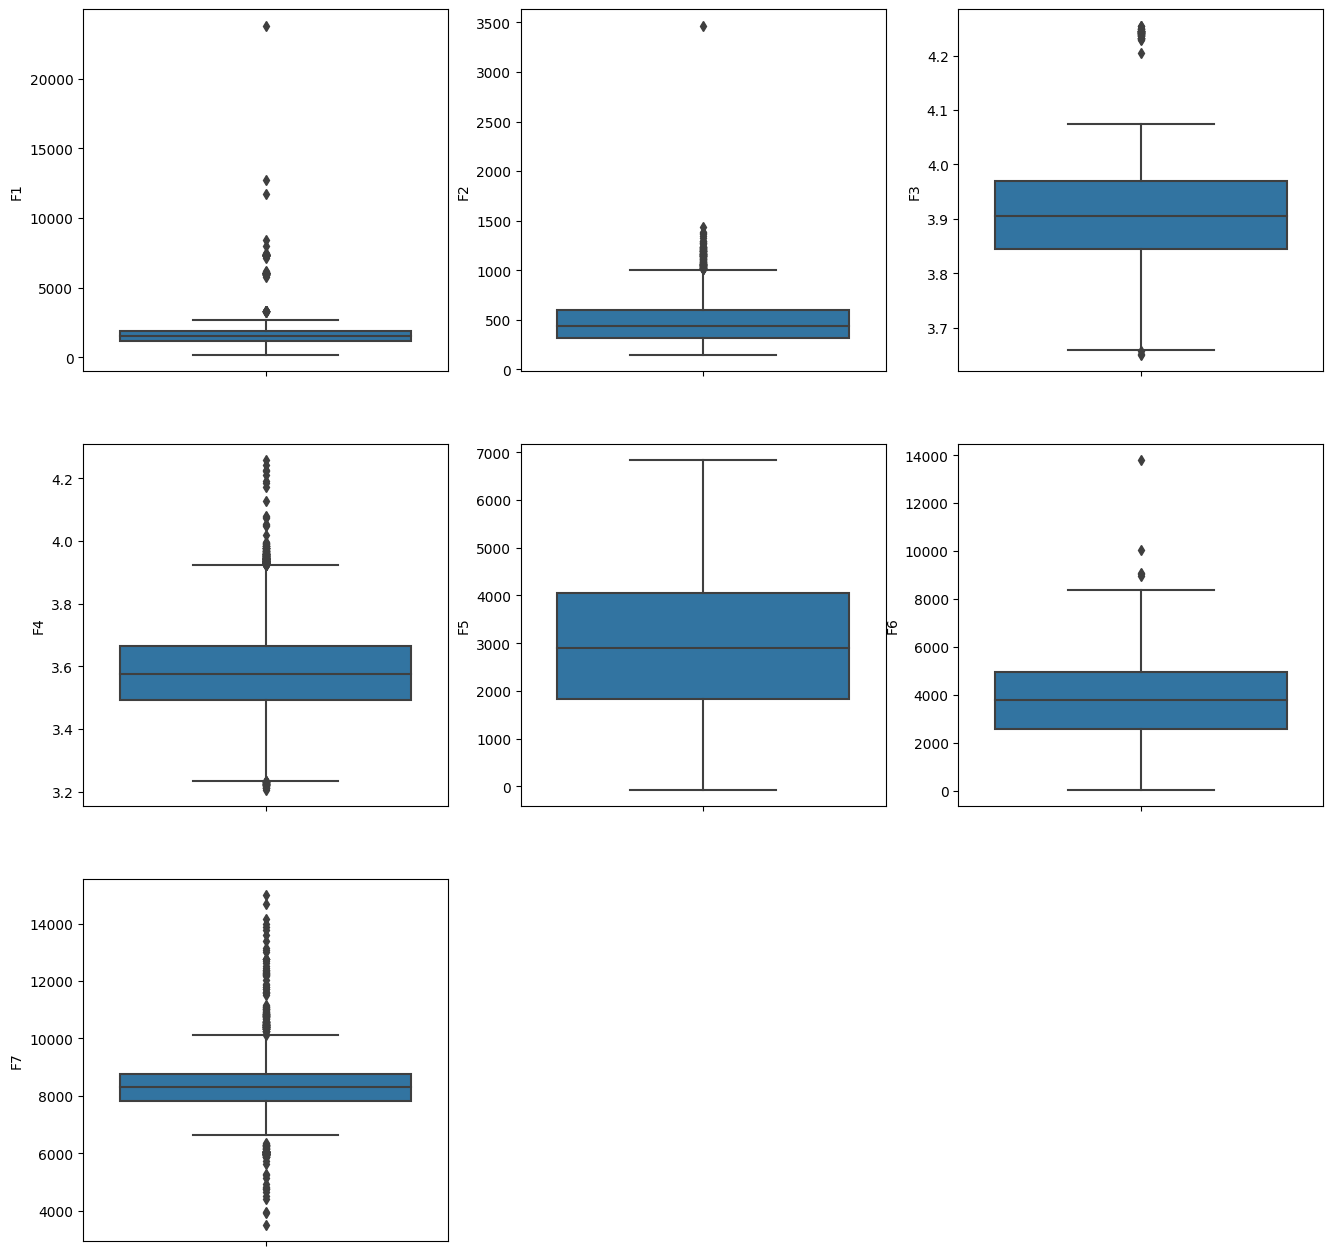

In [19]:
plt.figure(figsize=(16,16))

for i,col in enumerate(new_col_labels):    
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=col, data=dfc)

plt.show()

In [20]:
# Все еще значительные выбросы у F1 и F2, уберем их

In [21]:
dfc = dfc[df.F1 < 10000]
dfc = dfc[df.F2 < 3000]

C:\Users\Peter\AppData\Local\Temp\ipykernel_6684\2490842494.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfc = dfc[df.F1 < 10000]
C:\Users\Peter\AppData\Local\Temp\ipykernel_6684\2490842494.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfc = dfc[df.F2 < 3000]


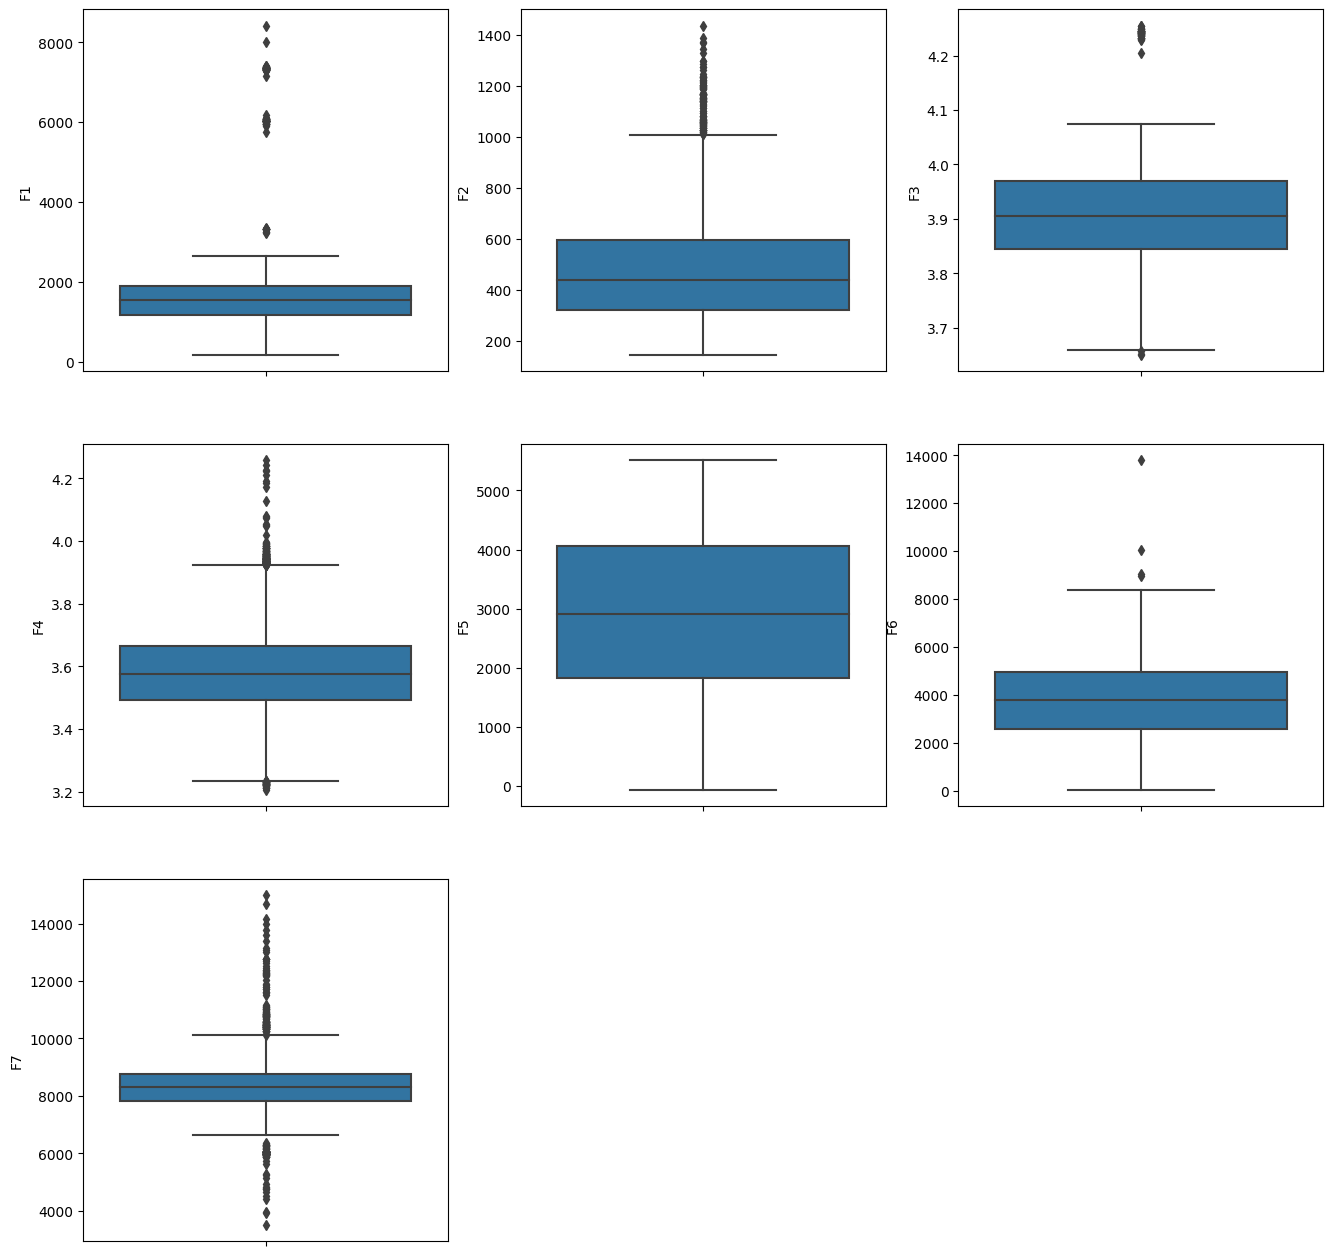

In [22]:
plt.figure(figsize=(16,16))

for i,col in enumerate(new_col_labels):    
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=col, data=dfc)

plt.show()

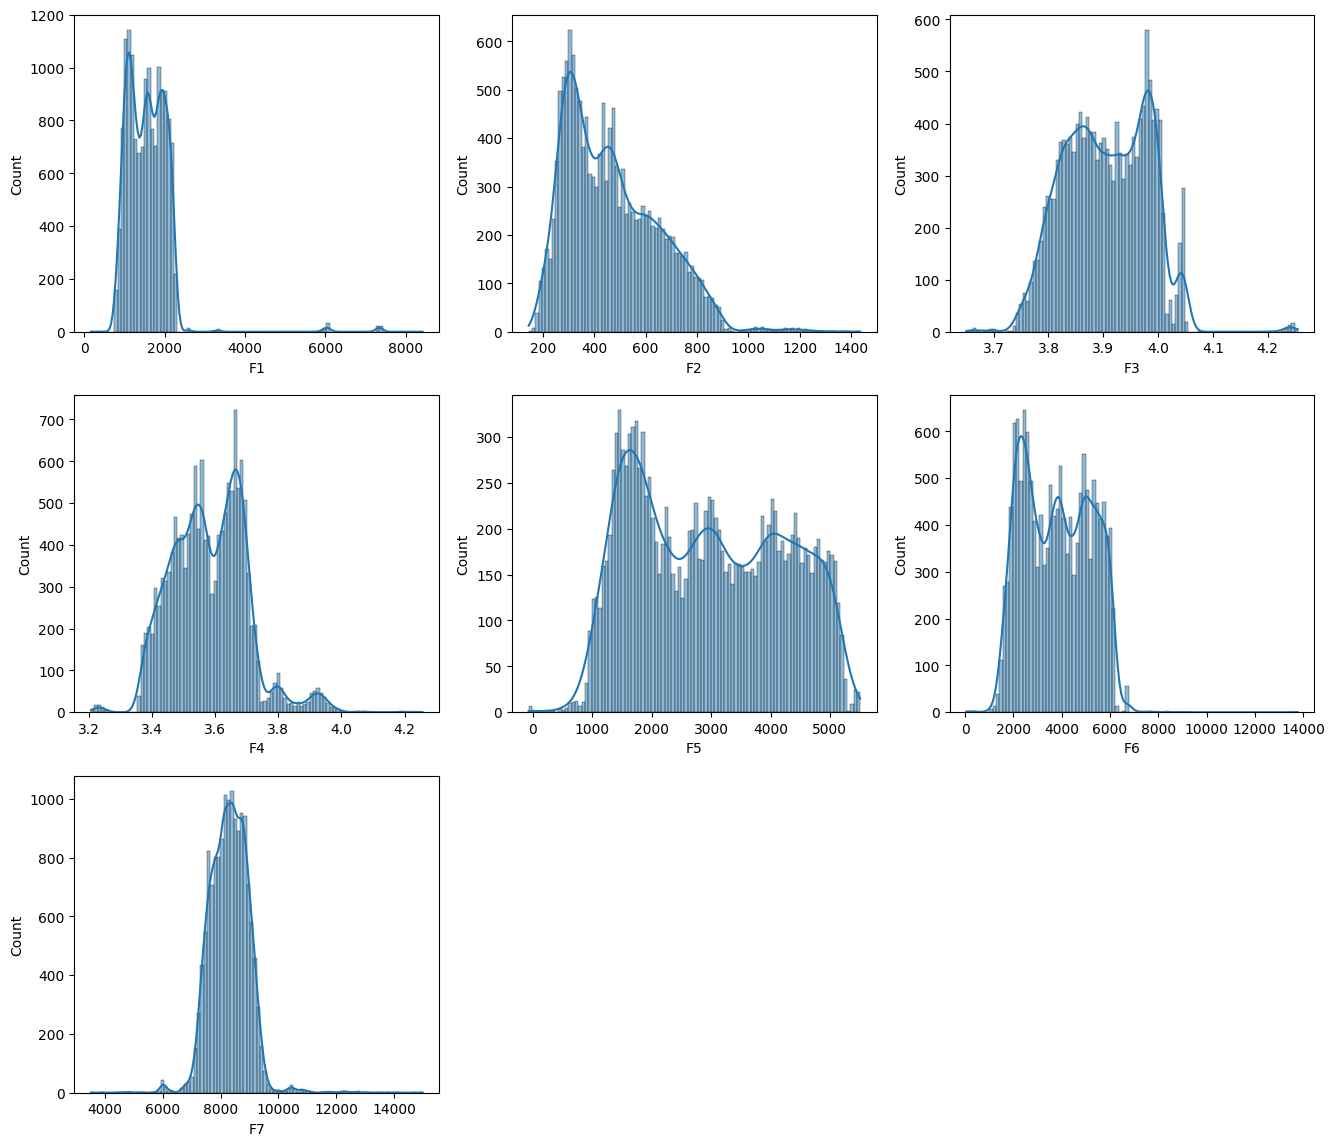

In [23]:
plt.figure(figsize=(16,14))

for i,col in enumerate(new_col_labels):    
    plt.subplot(3, 3, i + 1)
    sns.histplot(x=col, data=dfc, bins=100, kde=True)

plt.show()

In [24]:
print('Отброшено {:.2f}% или {} значений.'.format(100*(1-dfc.shape[0]/df.shape[0]), df.shape[0] - dfc.shape[0]))
print('Осталось {} из {} значений.'.format(dfc.shape[0], df.shape[0]))

Отброшено 1.45% или 219 значений.
Осталось 14845 из 15064 значений.


In [25]:
dfc.reset_index(drop=True, inplace=True)

In [26]:
# dfc.to_csv('data/Battery_RUL_cleaned.csv')

In [27]:
# dfc = pd.read_csv('data/Battery_RUL_cleaned.csv', index_col=0)

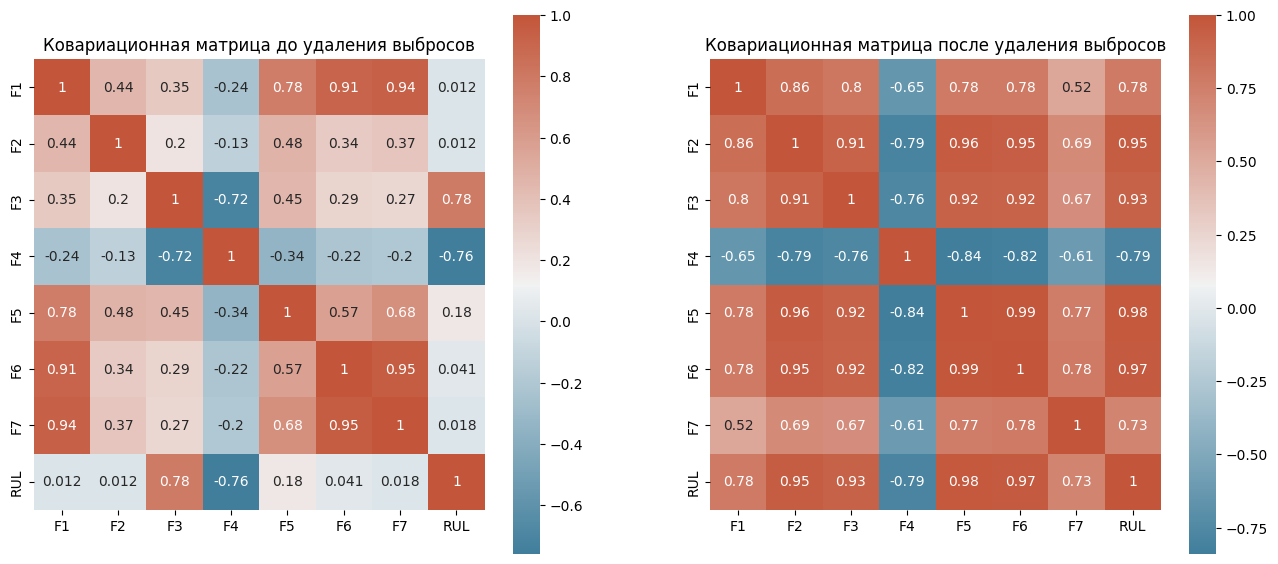

In [28]:
plt.figure(figsize=(16, 7))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.subplot(1, 2, 1)
plt.title('Ковариационная матрица до удаления выбросов')
sns.heatmap(df.corr(), cmap=cmap, annot=True, square=True)
plt.subplot(1, 2, 2)
plt.title('Ковариационная матрица после удаления выбросов')
sns.heatmap(dfc.corr(), cmap=cmap, annot=True, square=True)

plt.show()

In [29]:
# Признаки сильно коррелируют между собой!!!

### Нормализация

In [30]:
MMS_X = MinMaxScaler()
mms_y = MinMaxScaler()

In [31]:
df_X = pd.DataFrame( MMS_X.fit_transform(dfc.iloc[:,:-1]), columns=list(dfc.columns[:-1]) )
df_y = pd.DataFrame( mms_y.fit_transform(dfc[['RUL']]), columns=['RUL'] )

### PCA

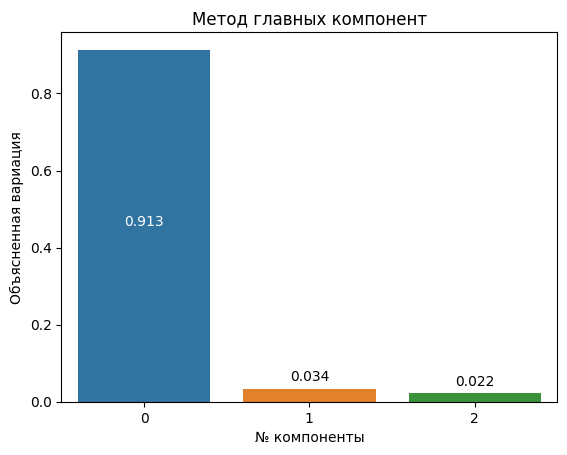

In [32]:
pca = PCA(n_components=3, random_state=0)
pca.fit_transform(df_X)

evr = pca.explained_variance_ratio_
ax=sns.barplot(x=[0,1,2], y=evr)
plt.title('Метод главных компонент')
plt.xlabel('№ компоненты')
plt.ylabel('Объясненная вариация')

ax.text(0, evr[0]/2, round(evr[0],3), color='white', ha='center')
ax.text(1, evr[1] + 0.02, round(evr[1],3), color='black', ha='center')
ax.text(2, evr[2] + 0.02, round(evr[2],3), color='black', ha='center')

plt.show()

In [33]:
# Вывод: данные практически одномерны

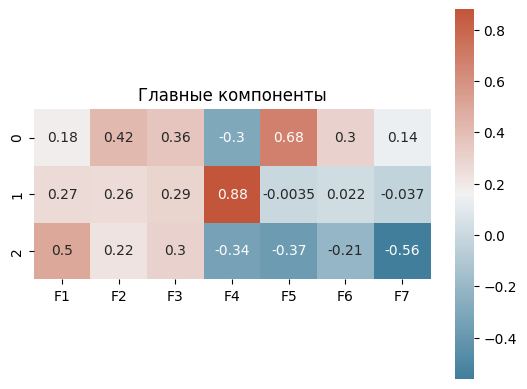

In [34]:
plt.title('Главные компоненты')
sns.heatmap(pd.DataFrame(pca.components_, columns=df_X.columns), cmap=cmap, annot=True, square=True)
plt.show()

## Регрессия

### Датасет для сбора метрик регрессоров

In [35]:
metrics = pd.DataFrame(
    
    index=[
        'Linear','Ridge','kNN'
        ,'RandomForest'
        ,'Polynomial'
        ,'GradientBoosting'
        ,'DenseNN'
    ], 
    
    columns=['R2_best','R2_1_feature','R2_2_features','R2_3_features',
             'MAE_best','MAE_1_feature','MAE_2_features', 'MAE_3_features'])

### Вспомогательная функция для подбора признаков, кросс-валидации и сохранения метрик

In [334]:
def apply_regressor(reg, X, y):
    
    """
    Для регрессора reg функция проводит подбор признаков и кросс-валидацию 
    на оптимальных наборах, и возвращает список метрик: 
    
    R2 - лучшая во всем тесте
    R2 - лучшая при регрессии на 1 признаке
    R2 - лучшая при регрессии на 2 признаках
    R2 - лучшая при регрессии на 3 признаках
    MAE - лучшая во всем тесте (см. замечание ниже)
    MAE - при регрессии на 1 признаке
    MAE - при регрессии на 2 признаках
    MAE - при регрессии на 3 признаках
    
    Замечание: SequentialFeatureSelector производит сравнение по R2. Поэтому значения MAE, 
    возвращаемые данной функцией apply_regressor, не обязательно будут самыми лучшими, и должны
    интерпретироваться как значения MAE, соответствующие лучшим значениям R2 (т.е. полученные
    на наборах признаков, оптимальных по критерию R2).
    
    """
    
    R2_best = 0.0
    R2_1_feature = 0.0
    R2_2_features = 0.0
    R2_3_features = 0.0
    MAE_best = 1e100
    MAE_1_feature = 0.0
    MAE_2_features = 0.0
    MAE_3_features = 0.0
    
    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    print('R2       RMSE    MAE     best features')
    print('-----------------------------------------------')

    n_col = X.shape[1]
    
    for n_f in range(1, n_col + 1):
    
        if n_f == n_col:
            df_Xf = X
        else:    
            sfs = SequentialFeatureSelector(reg, n_features_to_select=n_f)
            df_Xf = sfs.fit_transform(X, y)
    
        cv=cross_validate(reg, df_Xf, y, scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'], cv=kf)
    
        if n_f == n_col:
            best_f = '[ALL]'
        else:
            best_f = sfs.get_support(indices=True) + 1
    
        R2 = cv['test_r2'].mean()
        RMSE = -cv['test_neg_root_mean_squared_error'].mean()
        MAE = -cv['test_neg_mean_absolute_error'].mean()
        
        if n_f == 1:
            R2_1_feature = R2
            MAE_1_feature = MAE
        
        if n_f == 2:
            R2_2_features = R2
            MAE_2_features = MAE
            
        if n_f == 3:
            R2_3_features = R2
            MAE_3_features = MAE
            
        if R2 > R2_best: R2_best = R2
        if MAE < MAE_best: MAE_best = MAE
    
        # print(cv['test_r2'].std())
    
        print('{:.4f}   {:.2f}   {:.2f}  '.format(R2, RMSE, MAE), best_f)
        
    return [ R2_best, R2_1_feature, R2_2_features, R2_3_features, MAE_best, MAE_1_feature, MAE_2_features, MAE_3_features ]


Замечание: SequentialFeatureSelector производит сравнение по R2. Поэтому значения MAE, возвращаемые данной функцией apply_regressor, не обязательно будут самыми лучшими, и должны интерпретироваться как значения MAE, соответствующие лучшим значениям R2 (т.е. полученные на наборах признаков, оптимальных по критерию R2).

### Линейная регрессия

In [275]:
metrics.loc['Linear'] = apply_regressor(LinearRegression(), df_X, dfc.RUL)

R2       RMSE    MAE     best features
-----------------------------------------------
0.9553   67.85   42.86   [5]
0.9595   64.57   41.89   [4 5]
0.9635   61.43   42.71   [3 4 5]
0.9645   60.53   43.53   [3 4 5 7]
0.9649   60.22   43.41   [3 4 5 6 7]
0.9651   60.04   44.10   [2 3 4 5 6 7]
0.9653   59.86   44.75   [ALL]


### Ridge-регрессия (L2-регуляризация)

In [276]:
metrics.loc['Ridge'] = apply_regressor(Ridge(alpha=3.0), df_X, dfc.RUL)

R2       RMSE    MAE     best features
-----------------------------------------------
0.9553   67.87   42.88   [5]
0.9594   64.70   41.69   [4 5]
0.9633   61.54   42.69   [3 4 5]
0.9642   60.79   43.21   [3 4 5 7]
0.9646   60.43   43.05   [3 4 5 6 7]
0.9646   60.48   43.06   [1 3 4 5 6 7]
0.9651   60.10   44.82   [ALL]


### Метод k-ближайших соседей

In [277]:
metrics.loc['kNN'] = apply_regressor(KNeighborsRegressor(n_neighbors=4), df_X, dfc.RUL)

R2       RMSE    MAE     best features
-----------------------------------------------
0.9727   53.11   37.38   [1]
0.9773   48.48   33.10   [1 6]
0.9790   46.62   31.99   [1 5 6]
0.9866   37.21   22.83   [1 4 5 6]
0.9924   27.97   14.31   [1 2 4 5 6]
0.9952   22.31   9.41   [1 2 3 4 5 6]
0.9964   19.30   7.04   [ALL]


### Random Forest

In [278]:
# Внимание! Ячейка работает очень долго!
RFR1 = apply_regressor(RandomForestRegressor(random_state=0, n_estimators=60), df_X, dfc.RUL)

R2       RMSE    MAE     best features
-----------------------------------------------
0.9696   56.11   38.53   [1]
0.9784   47.30   32.03   [1 6]
0.9812   44.08   29.90   [1 5 6]
0.9912   30.10   18.11   [1 3 5 6]
0.9940   24.98   14.60   [1 2 3 5 6]
0.9956   21.33   11.43   [1 2 3 4 5 6]
0.9966   18.70   9.23   [ALL]


In [279]:
# Внимание! Ячейка работает очень долго!
RFR2 = apply_regressor(RandomForestRegressor(random_state=0, n_estimators=100), df_X, dfc.RUL)

R2       RMSE    MAE     best features
-----------------------------------------------
0.9696   56.08   38.51   [1]
0.9784   47.26   32.00   [1 6]
0.9813   43.96   29.83   [1 5 6]
0.9880   35.17   22.06   [1 4 5 6]
0.9924   28.04   16.69   [1 2 4 5 6]
0.9956   21.26   11.39   [1 2 3 4 5 6]
0.9966   18.74   9.23   [ALL]


In [280]:
# Внимание! Ячейка работает очень долго!
RFR3 = apply_regressor(RandomForestRegressor(random_state=0, n_estimators=200), df_X, dfc.RUL)

R2       RMSE    MAE     best features
-----------------------------------------------
0.9697   56.01   38.46   [1]
0.9784   47.23   31.98   [1 6]
0.9814   43.86   29.76   [1 5 6]
0.9914   29.81   17.96   [1 3 5 6]
0.9941   24.79   14.52   [1 2 3 5 6]
0.9957   21.19   11.34   [1 2 3 4 5 6]
0.9966   18.66   9.19   [ALL]


In [281]:
# Внимание! Ячейка работает очень долго!
RFR4 = apply_regressor(RandomForestRegressor(random_state=0, n_estimators=500), df_X, dfc.RUL)

R2       RMSE    MAE     best features
-----------------------------------------------
0.9697   55.97   38.44   [1]
0.9785   47.20   31.98   [1 6]
0.9814   43.82   29.74   [1 5 6]
0.9914   29.76   17.94   [1 3 5 6]
0.9941   24.77   14.50   [1 2 3 5 6]
0.9957   21.17   11.32   [1 2 3 4 5 6]
0.9966   18.63   9.17   [ALL]


In [282]:
# Внимание! Ячейка работает очень долго!
RFR5 = apply_regressor(RandomForestRegressor(random_state=0, n_estimators=1000), df_X, dfc.RUL)

R2       RMSE    MAE     best features
-----------------------------------------------
0.9697   55.97   38.43   [1]
0.9784   47.22   31.98   [1 6]
0.9814   43.82   29.74   [1 5 6]
0.9914   29.74   17.93   [1 3 5 6]
0.9941   24.79   14.49   [1 2 3 5 6]
0.9957   21.14   11.30   [1 2 3 4 5 6]
0.9966   18.62   9.16   [ALL]


In [301]:
RFR_all = [ RFR1, RFR2, RFR3, RFR4, RFR5 ]
RFR_R2_best = np.argmax( [ L[0] for L in RFR_all  ] )
print(RFR_R2_best)

4


In [303]:
metrics.loc['RandomForest'] = RFR_all[RFR_R2_best]

### Полиномиальная регрессия

In [40]:
poly = PolynomialFeatures(7, include_bias=False)
dfp = df_X.copy()
dfp = poly.fit_transform(dfp)
dfp = pd.DataFrame(dfp)
dfp.shape

(14845, 3431)

In [41]:
# Проверка корреляции новых признаков

lst = (dfp.corrwith(df_y.iloc[:,0]).abs().sort_values()).reset_index()
of = poly.get_feature_names_out()
for i in lst.index:
    lst.loc[i,'terms'] = of[lst.iloc[i,0]]

lst.tail(15)

,index,0,terms
3416,2,0.928035,F3
3417,110,0.929082,F5^2 F6
3418,112,0.930110,F5 F6^2
3419,33,0.933703,F6 F7
3420,111,0.934943,F5^2 F7
3421,113,0.935262,F5 F6 F7
3422,32,0.946105,F6^2
3423,22,0.949746,F3 F5
3424,23,0.950120,F3 F6
3425,1,0.950237,F2


In [42]:
# Самая лучшая корреляция по-прежнему у F5, новые признаки не смогли его обогнать

In [43]:
# Добавим три самых лучших новых признака

dfpoly = df_X.copy()
dfpoly['F8'] = df_X.F5*df_X.F6
dfpoly['F9'] = df_X.F5**2
dfpoly['F10'] = df_X.F5*df_X.F7

In [44]:
metrics.loc['Polynomial'] = apply_regressor(LinearRegression(), dfpoly, dfc.RUL)

R2       RMSE    MAE     features
--------------------------------------
0.9553   67.85   42.86   [5]
0.9595   64.57   41.89   [4 5]
0.9635   61.43   42.71   [3 4 5]
0.9641   60.86   42.84   [ 3  4  5 10]
0.9647   60.42   43.95   [ 2  3  4  5 10]
0.9653   59.85   43.72   [ 2  3  4  5  9 10]
0.9654   59.80   43.66   [ 2  3  4  5  6  9 10]
0.9658   59.42   44.43   [ 1  2  3  4  5  6  9 10]
0.9658   59.43   44.41   [ 1  2  3  4  5  6  8  9 10]
0.9667   58.64   44.28   [ALL]


In [45]:
# Вывод: нелинейность не настолько сильная

### Градиентный бустинг

In [340]:
# Оценим оптимальныое значение learning_rate на полном наборе признаков
# Внимание! Ячейка работает долго!

lr_best = 0
R2_best = 0

for i in range(200):
    learning_rate=0.01 + i/200
    cv=cross_validate(GradientBoostingRegressor(learning_rate=learning_rate), 
               df_X, dfc.RUL, scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'], 
               cv=KFold(n_splits=5, shuffle=True, random_state=0))
    R2 = cv['test_r2'].mean()
    print('{}  {:.4f}   {:.2f}   {:.2f}  '.format(i,
            R2, 
            -cv['test_neg_root_mean_squared_error'].mean(),
            -cv['test_neg_mean_absolute_error'].mean()))
    if R2 > R2_best:
        R2_best = R2
        lr_best = learning_rate
        
print('Лучшее значение R2: {} при learning_rate = {}'.format(R2_best, lr_best))

0  0.8422   127.77   108.12  
1  0.9284   86.06   71.83  
2  0.9611   63.42   52.50  
3  0.9736   52.24   42.18  
4  0.9786   47.00   36.70  
5  0.9808   44.57   34.00  
6  0.9818   43.37   32.59  
7  0.9822   42.85   31.94  
8  0.9827   42.30   31.43  
9  0.9831   41.79   31.03  
10  0.9833   41.60   30.80  
11  0.9834   41.46   30.64  
12  0.9835   41.32   30.49  
13  0.9838   40.94   30.23  
14  0.9839   40.75   30.04  
15  0.9841   40.51   29.87  
16  0.9846   39.95   29.45  
17  0.9846   39.89   29.38  
18  0.9849   39.45   29.02  
19  0.9852   39.17   28.79  
20  0.9854   38.88   28.57  
21  0.9856   38.59   28.44  
22  0.9856   38.54   28.28  
23  0.9861   37.89   27.87  
24  0.9862   37.74   27.69  
25  0.9862   37.78   27.64  
26  0.9863   37.62   27.61  
27  0.9867   37.08   27.23  
28  0.9869   36.87   27.10  
29  0.9868   36.98   27.05  
30  0.9869   36.84   26.99  
31  0.9873   36.28   26.62  
32  0.9872   36.45   26.57  
33  0.9872   36.31   26.57  
34  0.9872   36.39   2

In [342]:
print('Лучшее значение R2: {} при learning_rate = {}'.format(R2_best, lr_best))

Лучшее значение R2: 0.9908370115637359 при learning_rate = 0.665


In [343]:
# Внимание! Ячейка работает долго!
GBR1 = apply_regressor(GradientBoostingRegressor(random_state=0, learning_rate = lr_best - 0.02), df_X, dfc.RUL)

R2       RMSE    MAE     best features
-----------------------------------------------
0.9762   49.62   35.12   [1]
0.9788   46.80   33.78   [1 6]
0.9791   46.48   33.46   [1 5 6]
0.9815   43.74   31.21   [1 4 5 6]
0.9874   36.09   26.04   [1 3 4 5 6]
0.9886   34.37   24.42   [1 2 3 4 5 6]
0.9904   31.53   21.82   [ALL]


In [344]:
# Внимание! Ячейка работает долго!
GBR2 = apply_regressor(GradientBoostingRegressor(random_state=0, learning_rate = lr_best - 0.01), df_X, dfc.RUL)

R2       RMSE    MAE     best features
-----------------------------------------------
0.9758   50.06   35.28   [1]
0.9785   47.10   33.85   [1 6]
0.9788   46.77   33.60   [1 5 6]
0.9810   44.29   31.60   [1 4 5 6]
0.9874   36.15   25.77   [1 3 4 5 6]
0.9885   34.54   24.59   [1 2 3 4 5 6]
0.9906   31.25   21.75   [ALL]


In [345]:
# Внимание! Ячейка работает долго!
GBR3 = apply_regressor(GradientBoostingRegressor(random_state=0, learning_rate = lr_best), df_X, dfc.RUL)

R2       RMSE    MAE     best features
-----------------------------------------------
0.9756   50.26   35.43   [1]
0.9786   47.04   33.70   [1 6]
0.9787   46.88   33.73   [1 5 6]
0.9811   44.17   31.40   [1 4 5 6]
0.9875   36.02   25.75   [1 3 4 5 6]
0.9889   33.94   24.19   [1 2 3 4 5 6]
0.9908   30.82   21.37   [ALL]


In [346]:
# Внимание! Ячейка работает долго!
GBR4 = apply_regressor(GradientBoostingRegressor(random_state=0, learning_rate = lr_best + 0.01), df_X, dfc.RUL)

R2       RMSE    MAE     best features
-----------------------------------------------
0.9758   49.98   35.18   [1]
0.9789   46.76   33.54   [1 6]
0.9788   46.78   33.60   [1 5 6]
0.9812   44.15   31.29   [1 4 5 6]
0.9875   35.97   25.72   [1 3 4 5 6]
0.9887   34.12   24.20   [1 2 3 4 5 6]
0.9906   31.17   21.55   [ALL]


In [347]:
# Внимание! Ячейка работает долго!
GBR5 = apply_regressor(GradientBoostingRegressor(random_state=0, learning_rate = lr_best + 0.02), df_X, dfc.RUL)

R2       RMSE    MAE     best features
-----------------------------------------------
0.9756   50.24   35.39   [1]
0.9786   47.00   33.78   [1 6]
0.9787   46.89   33.55   [1 5 6]
0.9814   43.80   31.04   [1 4 5 6]
0.9876   35.86   25.52   [1 3 4 5 6]
0.9888   34.10   24.02   [1 2 3 4 5 6]
0.9904   31.49   21.69   [ALL]


In [348]:
GBR_all = [ GBR1, GBR2, GBR3, GBR4, GBR5 ]
GBR_R2_best = np.argmax( [ L[0] for L in GBR_all  ] )
print(GBR_R2_best)

2


In [349]:
metrics.loc['GradientBoosting'] = GBR_all[GBR_R2_best]

## Полносвязная нейронная сеть

In [163]:
def plot_loss(history, opt, act):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.legend()
    plt.title('Оптимизатор: {}, функция активации: {}'.format(opt, act))
    plt.grid(True)

### Выбор оптимизатора

100 эпох, 2 скрытых слоя по 35 нейронов, tanh и relu

- Adadelta - нет сходимости на 100 эпохах (отриц. R2), требуется несколько тысяч эпох, результат все равно хуже Adam

- Adagrad - нестабильные результаты, большой разброс R2

- Adam - стабильно R2 > 0.97, быстрая сходимость (40 эпох) - с relu. С tanh хуже: R2 < 0.97

- Adamax - почти как Adam, но чуть хуже

- Ftrl - нет сходимости на 100 эпохах (отриц. R2), требуется несколько тысяч эпох, результат все равно хуже Adam

- Nadam - R2 сопоставима с Adam, но иногда присутствуют пульсации, сходимость визуально медленнее

- RMSprop - чуть хуже Adamax, есть пульсации

- SGD - R2 < 0.96, сходимость медленнее, чем у Adam

У всех оптимизаторов результаты лучше с relu, чем с tanh

Лидер - Adam, 2-е место - Adamax

116/116 [==============================] - 0s 740us/step
0.9778312619510678 47.646944469830096 36.51145151652524


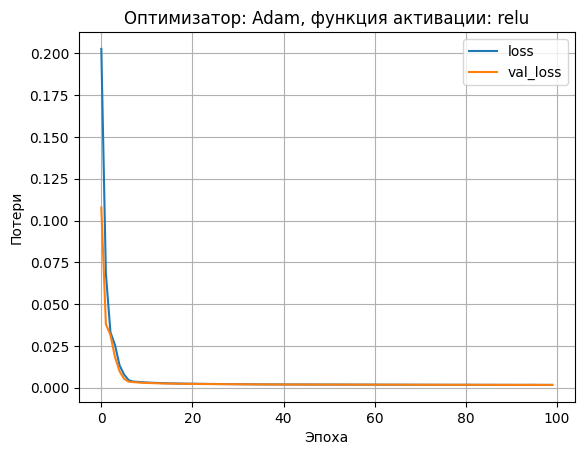

In [176]:
model = Sequential()
opt = 'Adam'
act = 'relu'
model.add(Dense(35, input_dim=7, activation=act))
model.add(Dense(35, activation=act))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer=opt)

df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_X, df_y, shuffle=True, random_state=0)
hist = model.fit(df_X_train, df_y_train, epochs=100, validation_split=0.2, batch_size=1000, verbose=0)
y_pred = model.predict(df_X_test)

df_y_test_inv = mms_y.inverse_transform(df_y_test)
y_pred_inv = mms_y.inverse_transform(y_pred)

print(r2_score(df_y_test, y_pred),
    mean_squared_error(df_y_test_inv, y_pred_inv)**0.5,
    mean_absolute_error(df_y_test_inv, y_pred_inv))

plot_loss(hist, opt, act)

Далее работаем только с Adam и relu

### Вспомогательная функция для кросс-валидации и сохранения метрик

In [311]:
def cross_val(X, y, input_dim):
    
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    R2_list = []
    RMSE_list = []
    MAE_list = []
    
    for i, (train_index, test_index) in enumerate(kf.split( X )):
        
        model = Sequential()
        model.add(Dense(50, input_dim=input_dim, activation='relu'))
        model.add(Dense(50, activation='relu'))
        model.add(Dense(1, activation='linear'))
        model.compile(loss='mse', optimizer='Adam')

        hist = model.fit(X.iloc[train_index], y.iloc[train_index], epochs=70, validation_split=0.2, batch_size=1000, verbose=0)
        y_pred = model.predict(X.iloc[test_index])
    
        y_test_inv = mms_y.inverse_transform(y.iloc[test_index])
        y_pred_inv = mms_y.inverse_transform(y_pred)
    
        R2 = r2_score(y.iloc[test_index], y_pred)
        RMSE = mean_squared_error(y_test_inv, y_pred_inv)**0.5
        MAE = mean_absolute_error(y_test_inv, y_pred_inv)
        
        R2_list.append(R2)
        RMSE_list.append(RMSE)
        MAE_list.append(MAE)
        
    return [ np.mean(R2_list), np.mean(RMSE_list), np.mean(MAE_list) ]
    

### Подбор признаков

In [354]:
best_R2 = [0,0,0,0,0,0,0]
best_MAE = [1e10,1e10,1e10,1e10,1e10,1e10,1e10]
best_features = [ [],[],[],[],[],[],[] ]

for i in range(1,128):
    
    print(i)
    
    X = df_X.iloc[:,[ 1 == (i // 2**n) % 2 for n in range(0,7)]]
    n_features = len(X.columns)
    
    (R2, _, MAE) = cross_val(X, df_y, n_features)
    
    if R2 > best_R2[n_features - 1]:
        best_R2[n_features - 1] = R2
        best_features[n_features - 1] = list(X.columns)
        #if best_MAE[n_features - 1] > MAE:
        best_MAE[n_features - 1] = MAE
    

1
93/93 [==============================] - 0s 799us/step
2
93/93 [==============================] - 0s 789us/step
3
93/93 [==============================] - 0s 797us/step
4
93/93 [==============================] - 0s 813us/step
5
93/93 [==============================] - 0s 787us/step
6
93/93 [==============================] - 0s 789us/step
7
93/93 [==============================] - 0s 815us/step
8
93/93 [==============================] - 0s 814us/step
9
93/93 [==============================] - 0s 802us/step
10
93/93 [==============================] - 0s 777us/step
11
93/93 [==============================] - 0s 788us/step
12
93/93 [==============================] - 0s 774us/step
13
93/93 [==============================] - 0s 773us/step
14
93/93 [==============================] - 0s 772us/step
15
93/93 [==============================] - 0s 832us/step
16
93/93 [==============================] - 0s 782us/step
17
93/93 [==============================] - 0s 771us/step
18
93/93 [=============

93/93 [==============================] - 0s 717us/step
31
93/93 [==============================] - 0s 777us/step
32
93/93 [==============================] - 0s 823us/step
33
93/93 [==============================] - 0s 782us/step
34
93/93 [==============================] - 0s 811us/step
35
93/93 [==============================] - 0s 782us/step
36
93/93 [==============================] - 0s 776us/step
37
93/93 [==============================] - 0s 764us/step
38
93/93 [==============================] - 0s 764us/step
39
93/93 [==============================] - 0s 767us/step
40
93/93 [==============================] - 0s 859us/step
41
93/93 [==============================] - 0s 717us/step
42
93/93 [==============================] - 0s 788us/step
43
93/93 [==============================] - 0s 800us/step
44
93/93 [==============================] - 0s 792us/step
45
93/93 [==============================] - 0s 784us/step
46
93/93 [==============================] - 0s 775us/step
47
93/93 [=======

93/93 [==============================] - 0s 826us/step
60
93/93 [==============================] - 0s 780us/step
61
93/93 [==============================] - 0s 793us/step
62
93/93 [==============================] - 0s 755us/step
63
93/93 [==============================] - 0s 750us/step
64
93/93 [==============================] - 0s 768us/step
65
93/93 [==============================] - 0s 750us/step
66
93/93 [==============================] - 0s 772us/step
67
93/93 [==============================] - 0s 782us/step
68
93/93 [==============================] - 0s 780us/step
69
93/93 [==============================] - 0s 793us/step
70
93/93 [==============================] - 0s 834us/step
71
93/93 [==============================] - 0s 762us/step
72
93/93 [==============================] - 0s 762us/step
73
93/93 [==============================] - 0s 771us/step
74
93/93 [==============================] - 0s 755us/step
75
93/93 [==============================] - 0s 779us/step
76
93/93 [=======

93/93 [==============================] - 0s 779us/step
90
93/93 [==============================] - 0s 793us/step
91
93/93 [==============================] - 0s 754us/step
92
93/93 [==============================] - 0s 759us/step
93
93/93 [==============================] - 0s 752us/step
94
93/93 [==============================] - 0s 805us/step
95
93/93 [==============================] - 0s 732us/step
96
93/93 [==============================] - 0s 739us/step
97
93/93 [==============================] - 0s 753us/step
98
93/93 [==============================] - 0s 761us/step
99
93/93 [==============================] - 0s 767us/step
100
93/93 [==============================] - 0s 759us/step
101
93/93 [==============================] - 0s 805us/step
102
93/93 [==============================] - 0s 761us/step
103
93/93 [==============================] - 0s 755us/step
104
93/93 [==============================] - 0s 744us/step
105
93/93 [==============================] - 0s 746us/step
106
93/93 [

93/93 [==============================] - 0s 712us/step
119
93/93 [==============================] - 0s 728us/step
120
93/93 [==============================] - 0s 789us/step
121
93/93 [==============================] - 0s 781us/step
122
93/93 [==============================] - 0s 822us/step
123
93/93 [==============================] - 0s 837us/step
124
93/93 [==============================] - 0s 762us/step
125
93/93 [==============================] - 0s 757us/step
126
93/93 [==============================] - 0s 735us/step
127
93/93 [==============================] - 0s 750us/step


In [355]:
best_R2

[0.973561467456971,
 0.9751277420263136,
 0.9747605098306668,
 0.9761665802461778,
 0.9766136934959853,
 0.9768753035448603,
 0.9758799389693544]

In [356]:
print('Лучшее значение R2 достигается на {} признаках'.format(1 + np.argmax(best_R2)))

Лучшее значение R2 достигается на 6 признаках


У всех остальных регрессоров лучшее значение R2 достигается на полном наборе признаков (7)

In [357]:
best_MAE

[37.359428614291645,
 36.72317380889493,
 36.64220022209347,
 37.269023686949055,
 36.84971257253237,
 36.37053685127276,
 37.64716538693938]

In [358]:
best_features

[['F1'],
 ['F1', 'F3'],
 ['F1', 'F3', 'F7'],
 ['F1', 'F2', 'F5', 'F7'],
 ['F2', 'F3', 'F4', 'F5', 'F7'],
 ['F1', 'F2', 'F3', 'F5', 'F6', 'F7'],
 ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7']]

In [359]:
metrics.loc['DenseNN'] = [
    max(best_R2), best_R2[0], best_R2[1], best_R2[2], 
    min(best_MAE), best_MAE[0], best_MAE[1], best_MAE[2]]

## Сравнение регрессоров

In [360]:
metrics

,R2_best,R2_1_feature,R2_2_features,R2_3_features,MAE_best,MAE_1_feature,MAE_2_features,MAE_3_features
Linear,0.965325,0.955305,0.959547,0.963458,41.890696,42.862455,41.890696,42.709987
Ridge,0.965053,0.955281,0.959377,0.963327,41.688289,42.879856,41.688289,42.694885
kNN,0.996387,0.972703,0.977271,0.978987,7.044358,37.379774,33.104547,31.988329
RandomForest,0.996642,0.969702,0.978442,0.981426,9.163030,38.430279,31.977396,29.740954
Polynomial,0.966741,0.955305,0.959547,0.963458,41.890696,42.862455,41.890696,42.709987
GradientBoosting,0.990813,0.975557,0.978600,0.978744,21.365446,35.433984,33.701959,33.727206
DenseNN,0.976875,0.973561,0.975128,0.974761,36.370537,37.359429,36.723174,36.642200


In [365]:
# metrics.to_csv('data/regressor_metrics.csv')

In [308]:
# metrics = pd.read_csv('data/regressor_metrics.csv', index_col=0)

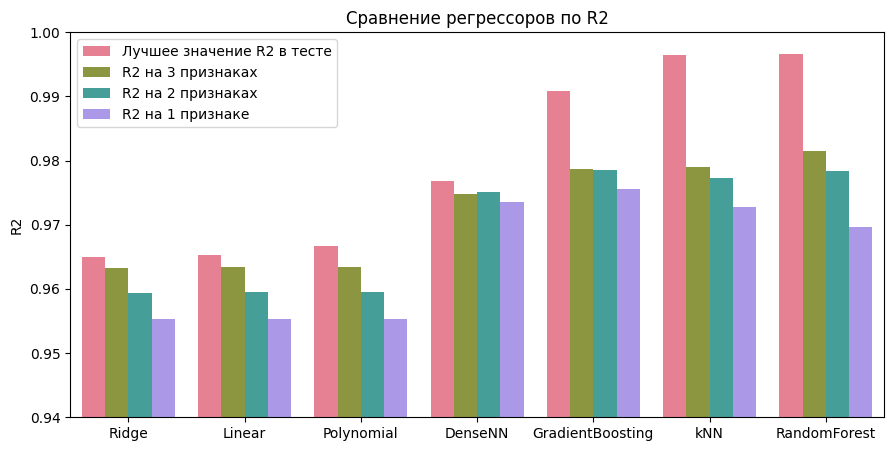

In [361]:
# R2

metrics_sorted = metrics.sort_values('R2_best')

metrics_melted = pd.melt(
    metrics_sorted.reset_index()[['index','R2_best','R2_3_features','R2_2_features','R2_1_feature']],
    id_vars='index')

bar_labels_r2 = {
        'R2_best' : 'Лучшее значение R2 в тесте',
        'R2_1_feature' : 'R2 на 1 признаке',
        'R2_2_features' : 'R2 на 2 признаках',
        'R2_3_features' : 'R2 на 3 признаках'
    }
    
metrics_melted.variable = metrics_melted.variable.apply(lambda x: bar_labels_r2[x])

plt.figure(figsize=(10.5, 5))
sns.barplot(data=metrics_melted, x='index', y='value', hue='variable', palette='husl')
plt.legend(loc='upper left')
plt.xlabel('')
plt.ylabel('R2')
plt.title('Сравнение регрессоров по R2')
plt.ylim(0.94, 1)
plt.show()

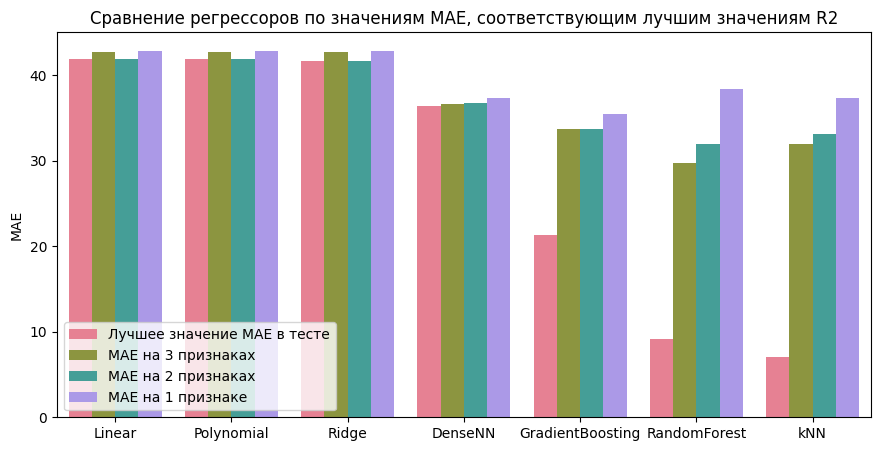

In [362]:
# MAE

metrics_sorted = metrics.sort_values('MAE_best', ascending=False)

metrics_melted = pd.melt(
    metrics_sorted.reset_index()[['index','MAE_best','MAE_3_features','MAE_2_features','MAE_1_feature']],
    id_vars='index')

bar_labels_mae = {
        'MAE_best' : 'Лучшее значение MAE в тесте',
        'MAE_1_feature' : 'MAE на 1 признаке',
        'MAE_2_features' : 'MAE на 2 признаках',
        'MAE_3_features' : 'MAE на 3 признаках'
    }
    
metrics_melted.variable = metrics_melted.variable.apply(lambda x: bar_labels_mae[x])

plt.figure(figsize=(10.5, 5))
sns.barplot(data=metrics_melted, x='index', y='value', hue='variable', palette='husl')
plt.legend(loc='lower left')
plt.xlabel('')
plt.ylabel('MAE')
plt.title('Сравнение регрессоров по значениям MAE, соответствующим лучшим значениям R2')
plt.show()

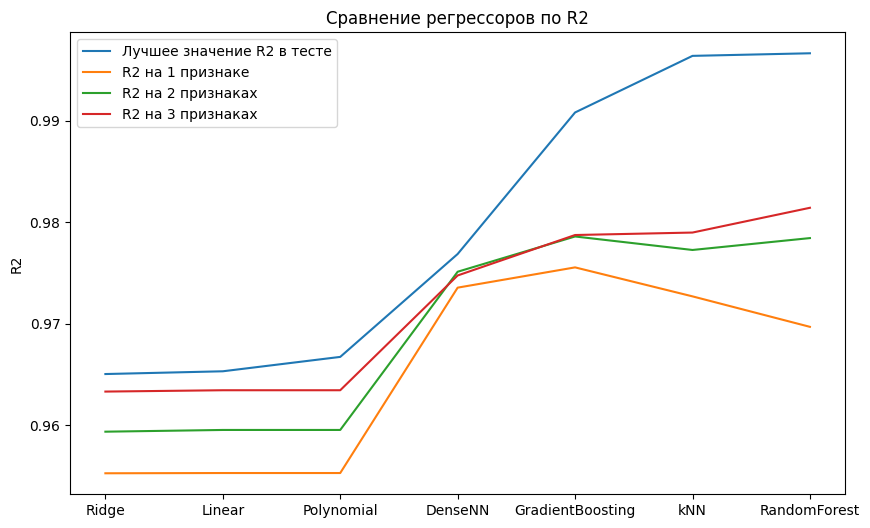

In [363]:
# R2

metrics_sorted = metrics.sort_values('R2_best')

plt.figure(figsize=(10,6))
plt.plot(metrics_sorted.index, metrics_sorted.R2_best, label='Лучшее значение R2 в тесте')
plt.plot(metrics_sorted.index, metrics_sorted.R2_1_feature, label='R2 на 1 признаке')
plt.plot(metrics_sorted.index, metrics_sorted.R2_2_features, label='R2 на 2 признаках')
plt.plot(metrics_sorted.index, metrics_sorted.R2_3_features, label='R2 на 3 признаках')
plt.ylabel('R2')
plt.title('Сравнение регрессоров по R2')
plt.legend()
plt.show()

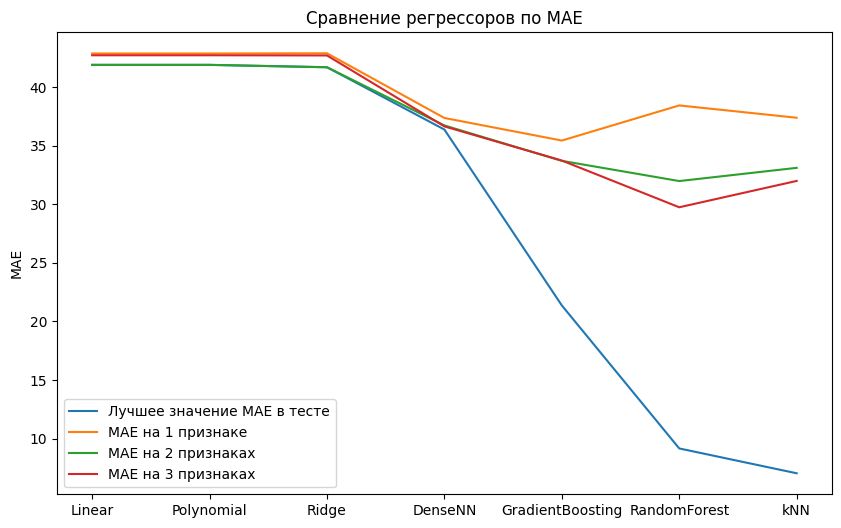

In [364]:
# MAE

metrics_sorted = metrics.sort_values('MAE_best', ascending=False)

plt.figure(figsize=(10,6))
plt.plot(metrics_sorted.index, metrics_sorted.MAE_best, label='Лучшее значение MAE в тесте')
plt.plot(metrics_sorted.index, metrics_sorted.MAE_1_feature, label='MAE на 1 признаке')
plt.plot(metrics_sorted.index, metrics_sorted.MAE_2_features, label='MAE на 2 признаках')
plt.plot(metrics_sorted.index, metrics_sorted.MAE_3_features, label='MAE на 3 признаках')
plt.ylabel('MAE')
plt.title('Сравнение регрессоров по MAE')
plt.legend()
plt.show()